In [1]:
import sys
sys.path.append('..')
import cortex_etl as c_etl

ma = c_etl.analysis_initial_processing("/gpfs/bbp.cscs.ch/project/proj83/home/isbister/physiology_2023/cortex_etl/configs/post_physiology_2023/debugging_tests/4_debugging_test_5_10_23.yaml", loglevel="ERROR")
a_hex0 = ma.hex0_spikes
c_etl.post_analysis(a_hex0)


----- Custom post analysis -----
----- Custom post analysis complete: 6.33s -----


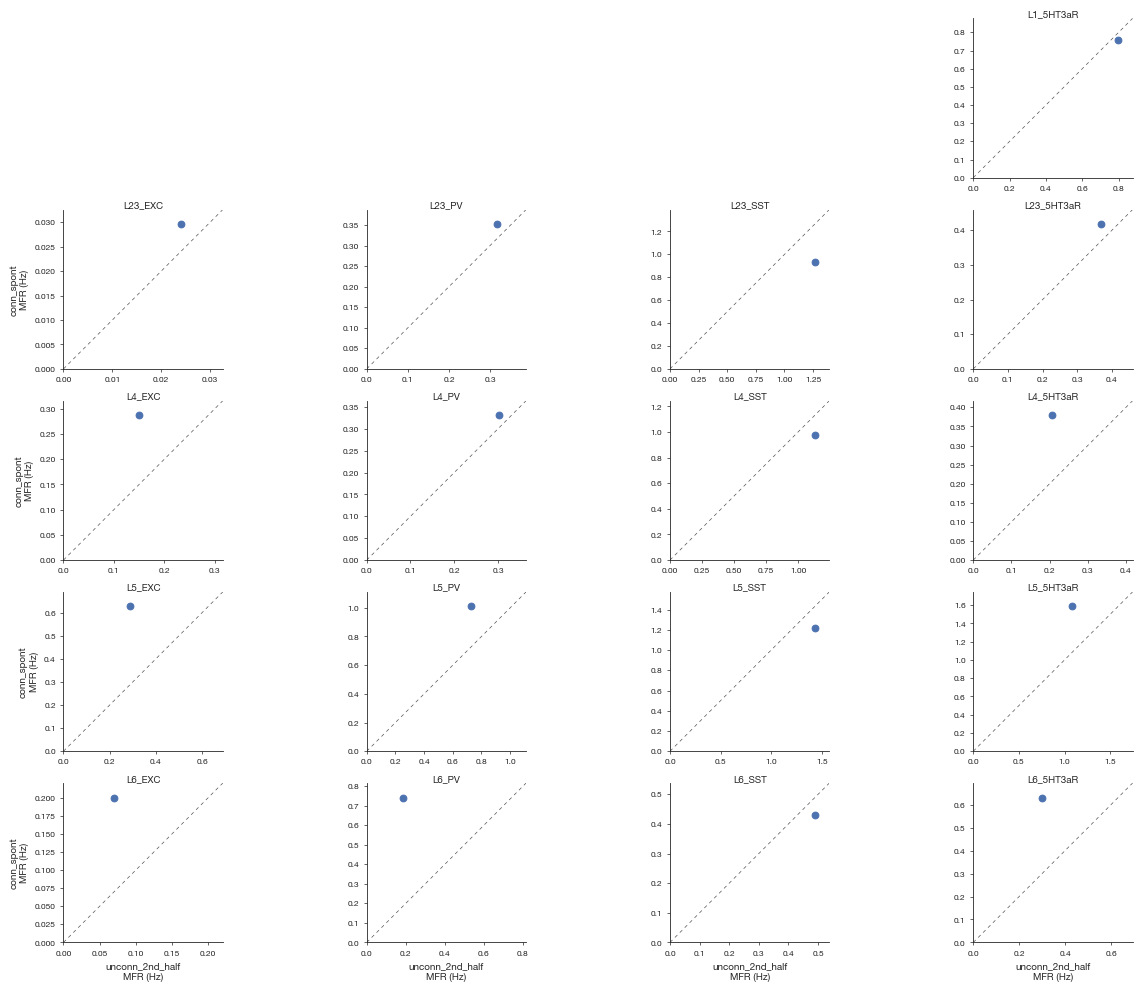

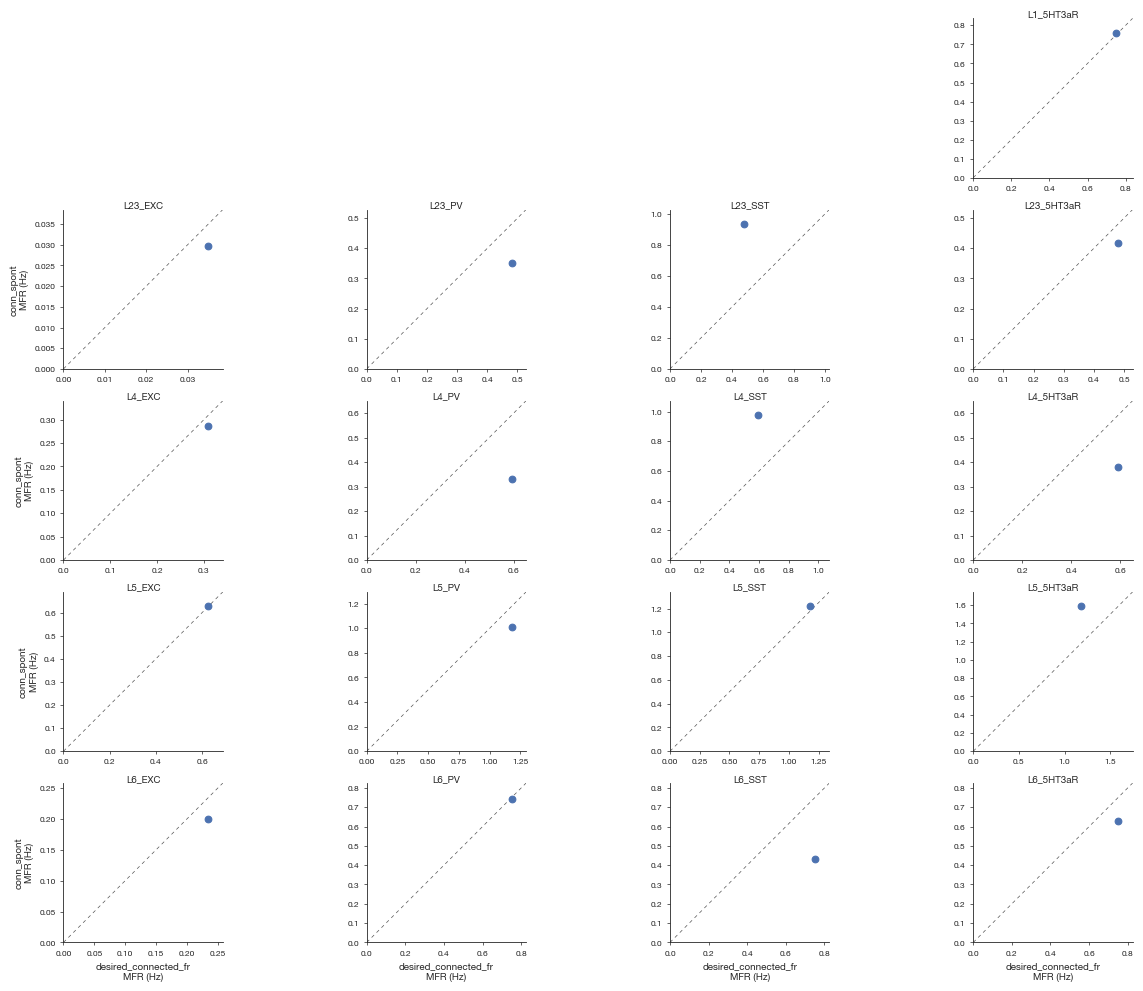

In [33]:
import pandas as pd
import numpy as np
# import sscx_calib
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.cm import ScalarMappable
import seaborn as sns
from matplotlib.ticker import MultipleLocator
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
import matplotlib.patheffects as mpe

def scatter_by_layer_and_class(base_df, a, comparison_pair):

    if (len(comparison_pair) == 3):
        fit_and_plot_exponential = comparison_pair[2]

    stat_key_1 = 'mean_of_mean_firing_rates_per_second'; 
    stat_key_2 = 'mean_of_mean_firing_rates_per_second';
    
    window_key_1 = comparison_pair[0]; 
    window_key_2 = comparison_pair[1]
    window_key_placeholder = "conn_spont"

    prespecified_keys = ['predicted_fr', 
                         'adjusted_unconnected_target_fr', 
                         'desired_connected_fr', 
                         'desired_unconnected_fr', 
                         'connection_fr_increase', 
                         'connection_fr_error', 
                         'recorded_proportion_of_in_vivo_FR', 
                         'desired_connected_proportion_of_invivo_frs']

    if (comparison_pair[0] in prespecified_keys):
        stat_key_1 = comparison_pair[0]
        window_key_1 = window_key_placeholder
    if (comparison_pair[1] in prespecified_keys):
        stat_key_2 = comparison_pair[1]
        window_key_2 = window_key_placeholder

    neuron_classes = [nc for group in c_etl.__dict__[a.analysis_config.custom['vertical_plot_seperate_groupings']] for nc in group]
    df1 = base_df.etl.q(window=window_key_1, neuron_class=neuron_classes)
    df2 = base_df.etl.q(window=window_key_2, neuron_class=neuron_classes)

    stat_filter = {}

    label = ''
    if (len(list(stat_filter.keys()))):
        df1 = df1.etl.q(stat_filter)
        df2 = df2.etl.q(stat_filter)

        label = list(stat_filter.keys())[0]   

    # FIGURE PREPREP
    all_neuron_types = [c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES[nc]['synapse_class'] for group in c_etl.__dict__[a.analysis_config.custom['vertical_plot_seperate_groupings']] for nc in group]
    unique_neuron_types = np.unique(all_neuron_types)
    num_neuron_types = len(unique_neuron_types)
    
    neuron_type_order = ["EXC", "INH", "PV", "SST", "5HT3aR"]
    unique_neuron_types_ordered = [nt for nt in neuron_type_order if nt in unique_neuron_types]
        

    all_layer_strings = [c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES[nc]['layer_string'] for group in c_etl.__dict__[a.analysis_config.custom['vertical_plot_seperate_groupings']] for nc in group]
    unique_layers = np.unique(all_layer_strings)
    num_layers = len(unique_layers)

    fig, axes = plt.subplots(nrows=num_layers, ncols=num_neuron_types, figsize=(3*num_layers, 3*num_neuron_types))

    for row_ind, layer_str in enumerate(unique_layers):
        for col_ind, neuron_type in enumerate(unique_neuron_types_ordered):

            ax = axes[row_ind][col_ind]

            neuron_class = layer_str + '_' + neuron_type

            nc_df1 = df1.etl.q(neuron_class=neuron_class)
            nc_df2 = df2.etl.q(neuron_class=neuron_class)

            if (len(nc_df1) & len(nc_df2)):

                stat_nc_df1 = nc_df1[stat_key_1]
                stat_nc_df2 = nc_df2[stat_key_2]

                ax.scatter(stat_nc_df1, stat_nc_df2)
                if (row_ind == num_layers - 1): ax.set_xlabel(comparison_pair[0] + '\nMFR (Hz)')
                if (col_ind == 0): ax.set_ylabel(comparison_pair[1] + '\nMFR (Hz)')

                lims = [0.0, np.max([np.max(stat_nc_df1), np.max(stat_nc_df2)])]
                lims[1] = lims[1] * 1.1
                ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, lw=0.5, dashes=(5, 5))
                
                ax.spines.right.set_visible(False)
                ax.spines.top.set_visible(False)
                ax.set_title(neuron_class, pad=-100)
                if (lims[0] != lims[1]):
                    ax.set_xlim(lims)
                    ax.set_ylim(lims)
                    
                ax.set_aspect('equal', 'box')
                    
            else: ax.axis('off')
                
a = a_hex0; base_df = a.custom['by_neuron_class']; comparison_pair = ["unconn_2nd_half", "conn_spont"]

scatter_by_layer_and_class(base_df, a, comparison_pair)
scatter_by_layer_and_class(base_df, a, ["desired_connected_fr", "conn_spont"])
